### Sentiment Analysis Using RNN

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Steps:

1. Importing (or installing) tensorflow and other packages on your system
2. Loading your data from disk
3. Data Preprocessing and visualization
4. Creating your training and testing splits
5. Defining your RNN model architecture
6. Compiling your RNN model
7. Training your model on your training data
8. Evaluating your model on your test data
9. Making predictions for unseen data

### 1. Importing packages on your system

In [2]:
# import libraries
import pandas as pd
import numpy as np
import re 
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix , accuracy_score, classification_report
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense,LSTM , GlobalMaxPooling1D
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import  Embedding
from tensorflow.keras.models import Sequential
import tensorflow as tf
import itertools

import seaborn as sns
sns.set()

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
print("Tensorflow Version: {}".format(tf.__version__))

Tensorflow Version: 2.12.0


### 2. Load data from disk

In [5]:
df = pd.read_csv("/content/drive/MyDrive/PGA14/Deep Learning/4.RNN/10. Sentiment Analysis Using RNN/dataset/IMDB Dataset.csv")

In [6]:
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [7]:
df.shape

(50000, 2)

In [8]:
# split the data set into train and test

df_train = df.iloc[:40000]
df_test = df.iloc[40000:]

# # write to disk 
df_train.to_csv("movie_reviews_train.csv", index=False)
df_test.to_csv("movie_reviews_test.csv", index=False)

In [9]:
# # read data
# df_train = pd.read_csv("dataset/movie_reviews_train.csv")
# df_test =  pd.read_csv("dataset/movie_reviews_test.csv")

In [10]:
# check the shape of the dataframe
print(df_train.shape) # this dataset contain 40000 records and 2 columns for training
print(df_test.shape) # this dataset contain 10000 records and 2 columns for testing

(40000, 2)
(10000, 2)


In [11]:
df_train.columns

Index(['review', 'sentiment'], dtype='object')

In [13]:
df_train["review"][5]

'Probably my all-time favorite movie, a story of selflessness, sacrifice and dedication to a noble cause, but it\'s not preachy or boring. It just never gets old, despite my having seen it some 15 or more times in the last 25 years. Paul Lukas\' performance brings tears to my eyes, and Bette Davis, in one of her very few truly sympathetic roles, is a delight. The kids are, as grandma says, more like "dressed-up midgets" than children, but that only makes them more fun to watch. And the mother\'s slow awakening to what\'s happening in the world and under her own roof is believable and startling. If I had a dozen thumbs, they\'d all be "up" for this movie.'

### 3. Data Preprocessing and Visualization

In [14]:
df_train.isnull().sum()

review       0
sentiment    0
dtype: int64

In [ ]:
import seaborn as sns
# sns.countplot(df_train["sentiment"])

In [16]:
Neg = round(df_train["sentiment"].value_counts()[1]/len(df_train) * 100, 2)
Pos = round(df_train["sentiment"].value_counts()[0]/len(df_train) * 100, 2)


print('This train_dataset contain {}% Negative Sentiment tweet'.format(Neg))
print('This train_dataset contain {}% Positive Sentiment tweet'.format(Pos))

This train_dataset contain 49.98% Negative Sentiment tweet
This train_dataset contain 50.02% Positive Sentiment tweet


In [17]:
# select relevent columns

In [18]:
# create a label columns using manual label encoding
lab = {"positive":1,"negative":0}
df_train['label']= df_train["sentiment"].map(lab)
df_train.head()

,review,sentiment,label
0,One of the other reviewers has mentioned that ...,positive,1
1,A wonderful little production. <br /><br />The...,positive,1
2,I thought this was a wonderful way to spend ti...,positive,1
3,Basically there's a family where a little boy ...,negative,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,1


In [19]:
def clean_review(text): 
    ''' 
    Utility function to clean review text by removing links, special characters 
    using simple regex statements. 
    '''
    return ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ", text).split()).lower()

# clean tweet 
df_train["clean_review"] = df_train["review"].apply(lambda text : clean_review(text))

In [20]:
df_train.head()

,review,sentiment,label,clean_review
0,One of the other reviewers has mentioned that ...,positive,1,one of the other reviewers has mentioned that ...
1,A wonderful little production. <br /><br />The...,positive,1,a wonderful little production br br the filmin...
2,I thought this was a wonderful way to spend ti...,positive,1,i thought this was a wonderful way to spend ti...
3,Basically there's a family where a little boy ...,negative,0,basically there s a family where a little boy ...
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,1,petter mattei s love in the time of money is a...


In [21]:
df_train = df_train[["clean_review", "label"]]

In [22]:
df_train.head()

,clean_review,label
0,one of the other reviewers has mentioned that ...,1
1,a wonderful little production br br the filmin...,1
2,i thought this was a wonderful way to spend ti...,1
3,basically there s a family where a little boy ...,0
4,petter mattei s love in the time of money is a...,1


In [23]:
# check for missing value 
df_train.isnull().sum()

clean_review    0
label           0
dtype: int64

In [24]:
# drop missing rows
# df_train = df_train.dropna()
# df_train.isnull().sum()

In [25]:
# convert training dataset into tensorflow dataset format
train_dataset = (
    tf.data.Dataset.from_tensor_slices(
        (
            tf.cast(df_train["clean_review"].values, tf.string),
            tf.cast(df_train['label'].values, tf.int32)
        )
    )
)

In [26]:
train_dataset

<_TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.int32, name=None))>

In [27]:
# print first five record from train dataset
for example, label in train_dataset.take(5):
    print("--"*50)
    print("example : ", example.numpy())
    print()
    print("label: ", label.numpy())

----------------------------------------------------------------------------------------------------
example :  b'one of the other reviewers has mentioned that after watching just 1 oz episode you ll be hooked they are right as this is exactly what happened with me br br the first thing that struck me about oz was its brutality and unflinching scenes of violence which set in right from the word go trust me this is not a show for the faint hearted or timid this show pulls no punches with regards to drugs sex or violence its is hardcore in the classic use of the word br br it is called oz as that is the nickname given to the oswald maximum security state penitentary it focuses mainly on emerald city an experimental section of the prison where all the cells have glass fronts and face inwards so privacy is not high on the agenda em city is home to many aryans muslims gangstas latinos christians italians irish and more so scuffles death stares dodgy dealings and shady agreements are never f

In [28]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

In [29]:
# create batches of the dataset

train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# now every batch will have 64 samples

In [30]:
# print first batch from train dataset

for example, label in train_dataset.take(1):
    print("example : ", example.numpy())
    print("-----------------------")
    print("label: ", label.numpy())
    print("-----------------------")
    print("total len: ", len(label.numpy()))

example :  [b'hilarious film i had a great time watching it the star cuneyt arkin sometimes credited as steve arkin is a popular actor from turkey he has played in lots of tough guy roles epic sword films and romances it was fun to see him with an international cast and some real lousy looking pair of gloves if i remember it was also dubbed in english which made things even more funnier kinda like seeing john wayne speak turkish'
 b'shame on julia roberts and john cusack they are so talented and should not have had any part in this movie the storyline was dumb and predictable the jokes were not funny the romance was not really romance i was all too happy when this movie ended'
 b'or maybe that s what it feels like anyway the bat people is about as flat as a rug bland as a sack of flour and as exciting as a rock and as intelligent as all three combined br br okay plot in a nutshell fitting vessel that a doctor moss gets bitten by a bat while checking out a cave with his wife mcandrew an

### 4. Creating your training and validation splits

In [ ]:
64 * 100

In [31]:
# create validation dataset
val_dataset = train_dataset.take(100) # 100 * 64 = 6400
train_dataset = train_dataset.skip(100) # 40000 - 6400 = 33600

# select first 100 batch from train dataset for validation data
# each bacth will contain 64 samples and skip first 100 batch from train dataset

### 5. Create the text encoder 


the raw text data needs to be processed before it can be used in a model. The simplest way to process text for training is using the
textvectorization layer this layer has many capbiliites.

In [32]:
# Create the layer, and pass the dataset text to the layer's .adapt method

VOCAB_SIZE = 1000
encoder = tf.keras.layers.experimental.preprocessing.TextVectorization(max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

In [33]:
# create vocabulary of words
vocab = np.array(encoder.get_vocabulary())

# print top 20 vocab
vocab[0:20]

array(['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'br', 'it', 'in',
       'i', 'this', 'that', 's', 'was', 'as', 'movie', 'for', 'with'],
      dtype='<U14')

In [34]:
len(vocab)

1000

In [35]:
encoded_example = encoder("This is a nice asdfasdf asdf dev pen!").numpy()

In [36]:
encoded_example 

array([ 12,   7,   4, 336,   1,   1,   1,   1])

In [37]:
encoder.get_vocabulary()[332]

'fan'

In [38]:
vocab

array(['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'br', 'it', 'in',
       'i', 'this', 'that', 's', 'was', 'as', 'movie', 'for', 'with',
       'but', 'film', 'you', 't', 'on', 'not', 'he', 'are', 'his', 'have',
       'be', 'one', 'all', 'at', 'they', 'by', 'an', 'who', 'so', 'from',
       'like', 'there', 'or', 'just', 'her', 'out', 'about', 'if', 'has',
       'what', 'some', 'good', 'can', 'more', 'when', 'very', 'she', 'up',
       'time', 'no', 'my', 'even', 'would', 'which', 'only', 'story',
       'really', 'see', 'their', 'had', 'me', 'well', 'were', 'we',
       'much', 'than', 'bad', 'get', 'people', 'been', 'great', 'will',
       'other', 'do', 'also', 'into', 'because', 'how', 'don', 'him',
       'most', 'first', 'made', 'its', 'then', 'make', 'them', 'way',
       'could', 'too', 'movies', 'after', 'any', 'characters', 'think',
       'watch', 'character', 'two', 'films', 'many', 'seen', 'plot',
       'being', 'never', 'love', 'acting', 'life', 'where', 'show'

with default settings, the process is not completely reversible. two reason for this
1. the dfualt value for preprocessing.textvectorization standrdize argument is "lower_and_strip_punctuation"
2. the limited vocabulary size and lack of character-based fallback result in some unknown tokens.

### 6. Defining your RNN model architecture

In [39]:
# create RNN model
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(input_dim=len(encoder.get_vocabulary()), 
                              output_dim=64, 
                              mask_zero=True), 
                             
    tf.keras.layers.SimpleRNN(64),
#     tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64))
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dense(1) # tf.keras.layers.Dense(3, activation="softmax")
])

# note: if you use activation =sigmoid you will get the probability score for model not the negative scores
# but if you use by defualt value then you will get negative and positive value


1. this model can be build as a tf.keras.Sequential.
2. the first layer is the encoder, which converts the text to a sequence of token indices.
3. after the encoder is an embedding layer. an embedding layer stores one vector per word. when called it converts the sequences
of word indices to sequences of vectors. theses vecotrs are trainable. after training (on enough data), words with similar meanings ofter have similar vectors
4. a recurrent neurel network (RNN) process sequences input by iterating through the elements. RNN pass the outputs from timestep to their input on the next timestep
- The tf.keras.layers.bidirectioinal wrapper can aslo be used with an rnn layer. this propagates the input forward and backwards through the rnn layer and then concatenates the final output
- the main advanatage to a bidirectional rnn is that the signal from the beginning of the input dosent need to be process all the way through very timestep to affect the output
- the main disadvantage of a bidirectional rnn is that you cant efficiently stream predictions as words are being added to the end 

5. after the rnn has converted the sequences to a single vector the tow layers.dense do some final processing, and convert from this vector representation to a single logit as the classification output.


In [40]:
# pass sample input

sample_text = ("the movie was  cool. the animatioin and the graphics i would not recommend this movie")

predictions = model.predict(np.array([sample_text]))
print(predictions)


1/1 [==============================] - 3s 3s/step
[[0.10916667]]


In [41]:
# play with models (uncomment one one layer at time and check the output)
model2 = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(input_dim=len(encoder.get_vocabulary()), output_dim=5, mask_zero=True),
    tf.keras.layers.SimpleRNN(5),
    # tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(5))
    tf.keras.layers.Dense(5, activation="relu"),
    tf.keras.layers.Dense(1)
])

sample_text = ("the movie was good")
predictions = model2(np.array([sample_text]))
print(predictions)

tf.Tensor([[0.01833492]], shape=(1, 1), dtype=float32)


### 7. Compiling your RNN model

In [42]:
# compile the model

# for binary classification
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])


# for 3 level 
# model.compile(loss='sparse_categorical_crossentropy',
#               optimizer=tf.keras.optimizers.Adam(1e-4),
#               metrics=['accuracy'])




### 8. Training your model on your training data

In [43]:
model.summary()
import joblib

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, None)             0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, None, 64)          64000     
                                                                 
 simple_rnn (SimpleRNN)      (None, 64)                8256      
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 76,481
Trainable params: 76,481
Non-trainable params: 0
____________________________________________________

In [ ]:
EPOCHS = 1

results =model.fit(train_dataset,
                  epochs=EPOCHS,
                  validation_data=val_dataset)

joblib.dump(results, "results.pkl")
model.save("sentiment.model", save_format="h5")

### 9. Evaluating your model on your test data

In [ ]:
sns.countplot(df_test["sentiment"])

In [45]:
Neg = round(df_test["sentiment"].value_counts()[1]/len(df_test) * 100, 2)
Pos = round(df_test["sentiment"].value_counts()[0]/len(df_test) * 100, 2)


print('This train_dataset contain {}% Neutral Sentiment tweet'.format(Neg))
print('This train_dataset contain {}% Positive Sentiment tweet'.format(Pos))

This train_dataset contain 49.93% Neutral Sentiment tweet
This train_dataset contain 50.07% Positive Sentiment tweet


In [46]:
# clean text
df_test["clean_review"] = df_test["review"].apply(lambda text : clean_review(text))

# create a label columns using manual label encoding
lab = {"positive":1,"negative":0}
df_test['label']= df_test["sentiment"].map(lab)
df_test.head(10)

,review,sentiment,clean_review,label
40000,First off I want to say that I lean liberal on...,negative,first off i want to say that i lean liberal on...,0
40001,I was excited to see a sitcom that would hopef...,negative,i was excited to see a sitcom that would hopef...,0
40002,When you look at the cover and read stuff abou...,negative,when you look at the cover and read stuff abou...,0
40003,"Like many others, I counted on the appearance ...",negative,like many others i counted on the appearance o...,0
40004,"This movie was on t.v the other day, and I did...",negative,this movie was on t v the other day and i didn...,0
40005,Hickory Dickory Dock was a good Poirot mystery...,positive,hickory dickory dock was a good poirot mystery...,1
40006,"""One Crazy Summer"" is the funniest, craziest (...",positive,one crazy summer is the funniest craziest not ...,1
40007,Low-budget schlockmeister Herschell Gordon Lew...,negative,low budget schlockmeister herschell gordon lew...,0
40008,this was absolutely the most tragic pile of ci...,negative,this was absolutely the most tragic pile of ci...,0
40009,I have never understood the appeal of this sho...,negative,i have never understood the appeal of this sho...,0


In [47]:
df_test = df_test[["clean_review", "label"]]
df_test.head()

,clean_review,label
40000,first off i want to say that i lean liberal on...,0
40001,i was excited to see a sitcom that would hopef...,0
40002,when you look at the cover and read stuff abou...,0
40003,like many others i counted on the appearance o...,0
40004,this movie was on t v the other day and i didn...,0


In [ ]:
# check missing values 
df_test.isna().sum()

In [48]:
# convert testing dataset into tensorflow dataset format

test_dataset = (
    tf.data.Dataset.from_tensor_slices(
        (
            tf.cast(df_test["clean_review"].values, tf.string),
            tf.cast(df_test['label'].values, tf.int32)
        )
    )
)

# creeate batches in test dataset
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)


In [49]:
for example, label in test_dataset.take(1):
    print("example : ", example.numpy())
    print("-----------------------")
    print("label: ", label.numpy())
    print("-----------------------")
    print("total len: ", len(label.numpy()))

example :  [b'first off i want to say that i lean liberal on the political scale and i found the movie offensive i managed to watch the whole doggone disgrace of a film this movie brings a low to original ideas yes it was original thus my 2 stars instead of 1 are our film writers that uncreative that they can only come up with this acting was horrible and the characters were unlikeable for the most part the lead lady in the story had no good qualities at all they made her bf into some sort of a bad guy and i did not see that at all maybe i missed something i do not know he was the most down to earth relevant character in the movie i did not shell out any money for this garbage i almost wish peta would come to the rescue of this awful offensive movie and form a protest disgusting thats all i have to say anymore'
 b'i was excited to see a sitcom that would hopefully represent indian candians but i found this show to be not funny at all the producers and cast are probably happy to get bot

In [50]:
test_loss, test_acc = model.evaluate(test_dataset)

157/157 [==============================] - 18s 113ms/step - loss: 0.5088 - accuracy: 0.7893


In [ ]:
print("Test Loss: {}".format(test_loss))
print("Test Accuracy: {}".format(test_acc))

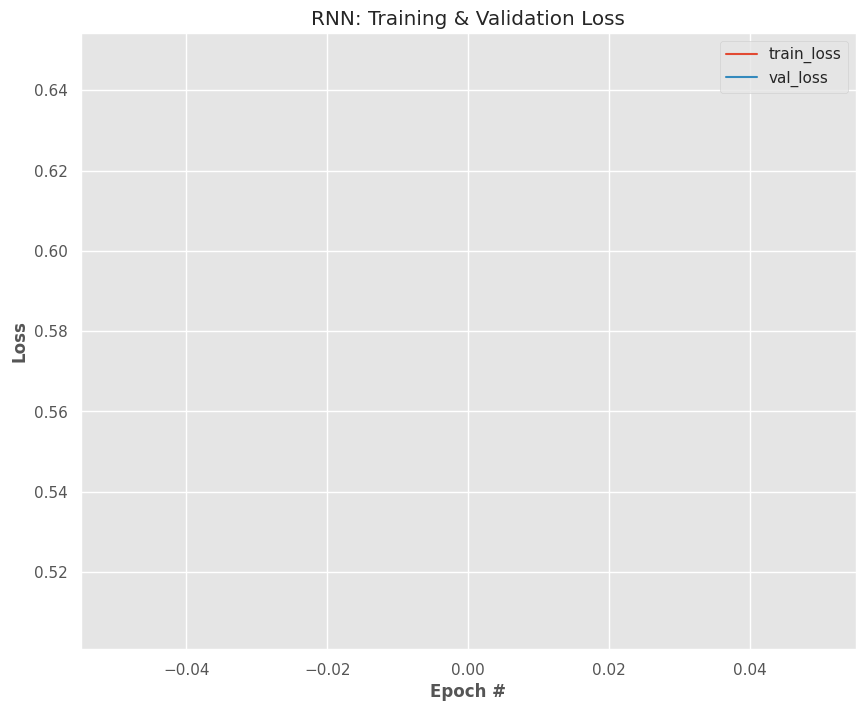

In [51]:
# plot the training and validation loss
N = np.arange(0, EPOCHS)
plt.style.use("ggplot")
plt.figure(figsize = [10,8])
plt.plot(N, results.history["loss"], label="train_loss")
plt.plot(N, results.history["val_loss"], label="val_loss")
plt.title("RNN: Training & Validation Loss")
plt.xlabel("Epoch #", weight="bold")
plt.ylabel("Loss", weight="bold")
plt.legend()
plt.show()

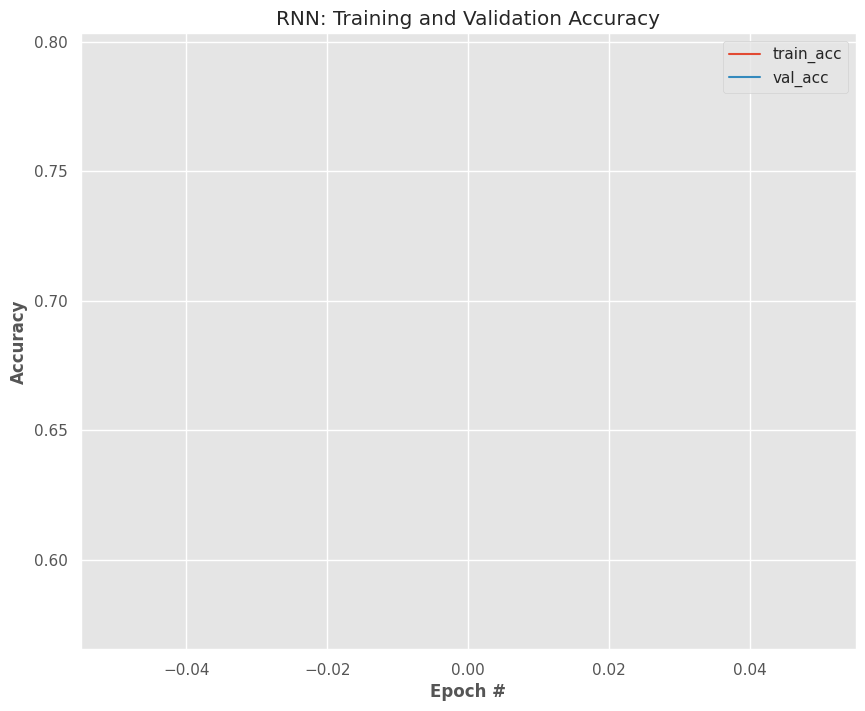

In [52]:
# plot the training and validation accuracy
N = np.arange(0, EPOCHS)
plt.style.use("ggplot")
plt.figure(figsize = [10,8])
plt.plot(N, results.history["accuracy"], label="train_acc")
plt.plot(N, results.history["val_accuracy"], label="val_acc")
plt.title("RNN: Training and Validation Accuracy")
plt.xlabel("Epoch #", weight="bold")
plt.ylabel("Accuracy", weight="bold")
plt.legend()
plt.show()

In [53]:
# predict on a sample text 

sample_text = ("The movie was not Good, I would not recommend this movie.")

prediction = model.predict(np.array([sample_text]))
print(prediction)

if prediction[0][0] >= 0:
    print("positive")
else:
    print("negative")


1/1 [==============================] - 0s 182ms/step
[[0.1150753]]
positive


In [ ]:

# for 3 level
# if np.argmax(prediction) == 0:
#     print("Neutral")
# elif np.argmax(prediction) == 1:
#     print("Positive")
# else:
#     print("Negative")

### 10. Saving the model

In [59]:
# save the model to disk
print("[INFO] serializing network...")
model.save("sentiment_RNN_1epochs.model", save_format="tf")

[INFO] serializing network...


In [ ]:
from tensorflow.keras.models import load_model
new_model = load_model("model/sentiment_RNN_15epochs.model")
print("[INFO] model loaded succesfully..")

In [ ]:
new_model.summary()

### 11. Making predictions for unseen data

In [ ]:
# check missing value 
df_test.isnull().sum()

In [ ]:
df_test.head()

In [ ]:
# Drop rows with any NaN in the clean text column only
# df_test = df_test.dropna(how='any', subset=['clean_review'])

In [ ]:
# check missing value 
# df_test.isnull().sum()

In [ ]:
# prediction on unseen data
y_pred = model.predict(np.array(df_test["clean_review"]))

In [ ]:
y_pred[:10] # confidence for each class

In [ ]:
# convert conf to 1 if +conf else 0
y_pred_bool = []
for conf in y_pred:
    if conf[0] >= 0:
        y_pred_bool.append(1)
    else:
        y_pred_bool.append(0)

df_test["pred"] = y_pred_bool

In [ ]:
# create new column for prediction on 3 label
# df_test["Predicted_label"] = np.argmax(y_pred, axis=1)

In [ ]:
df_test.head()

### 12. confusion matrix 

In [ ]:
def plot_confusion_metrix(y_true, y_pred,classes,
                         normalize=False,
                         title='Confusion Matrix',
                         cmap=plt.cm.Blues):
    """
    Objective
    ----------
    plot confussion matrix, classification report and accuracy score
    
    parameters
    ----------
    y_true : array-like of shape (n_samples,)
        Ground truth (correct) target values.

    y_pred : array-like of shape (n_samples,)
        Estimated targets as returned by a classifier.
    
    classes : list
        List of labels to index the matrix
        
    title : title for matrix
    cmap : colormap for matrix 
    
    returns 
    ----------
   all accruacy matrix 
    """
    
    
    cm = confusion_matrix(y_true,y_pred)
    
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized Confusion Matrix")
    else:
        print("Confusion Matrix, Without Normalisation")

    
    plt.imshow(cm, interpolation='nearest',cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks,classes,rotation=35)
    plt.yticks(tick_marks,classes)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() /2.
    
    for i , j in itertools.product(range(cm.shape[0]), range(cm.shape[0])):
        plt.text(j, i, format(cm[i,j], fmt),
                 horizontalalignment='center',
                 color='white' if cm[i, j] > thresh else 'black')
    
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    # plt.tight_layout()
    
    plt.show()
    
    print("-----------------------------------------------------")
    print('Classification report')
    print(classification_report(y_true,y_pred))
    
    print("-----------------------------------------------------")
    acc= accuracy_score(y_true,y_pred)
    print("Accuracy of the model: ", acc)

In [ ]:
plot_confusion_metrix(df_test["label"], df_test["pred"],classes=["negative: 0","positive: 1"])

### 13. final submission 

In [ ]:
def label(a):
    if a==0:
        return "Negative"
    elif a==1:
        return "Positive"
    

In [ ]:
df_test["pred"] = df_test["pred"].apply(lambda a : label(a))
df_test["label"] = df_test["label"].apply(lambda a : label(a))

In [ ]:
df_test.head()

In [ ]:
df_test.to_csv("dataset/Test_Predictioin.csv", index=False)

### 14. Future scope

return_sequence :
    - false: it returns only the last output for each input sequence (a 2D tensor of shape (batch_size, output_features)). this is the default
        used in previous model
    - true: the full sequences of successive outputs for each timestep is returned (a 3D tensor of shape(batch_size, timesteps, output_features))

the intresting thing about using an rnn with return sequences=true is that the output still has 3axes like the input so it can be passed to another rnn layer like this.    

### THE END